In [2]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..', '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from src.LoadEcoCounterData import EcoCounterData as BikeData

import matplotlib.pyplot as plt
import src.Colortheme as ct
from tueplots import bundles

import numpy as np
from shapely.geometry import LineString

# Paper Figure: Daily Counter Direction (In/Out) Comparison

In [3]:
bd = BikeData()

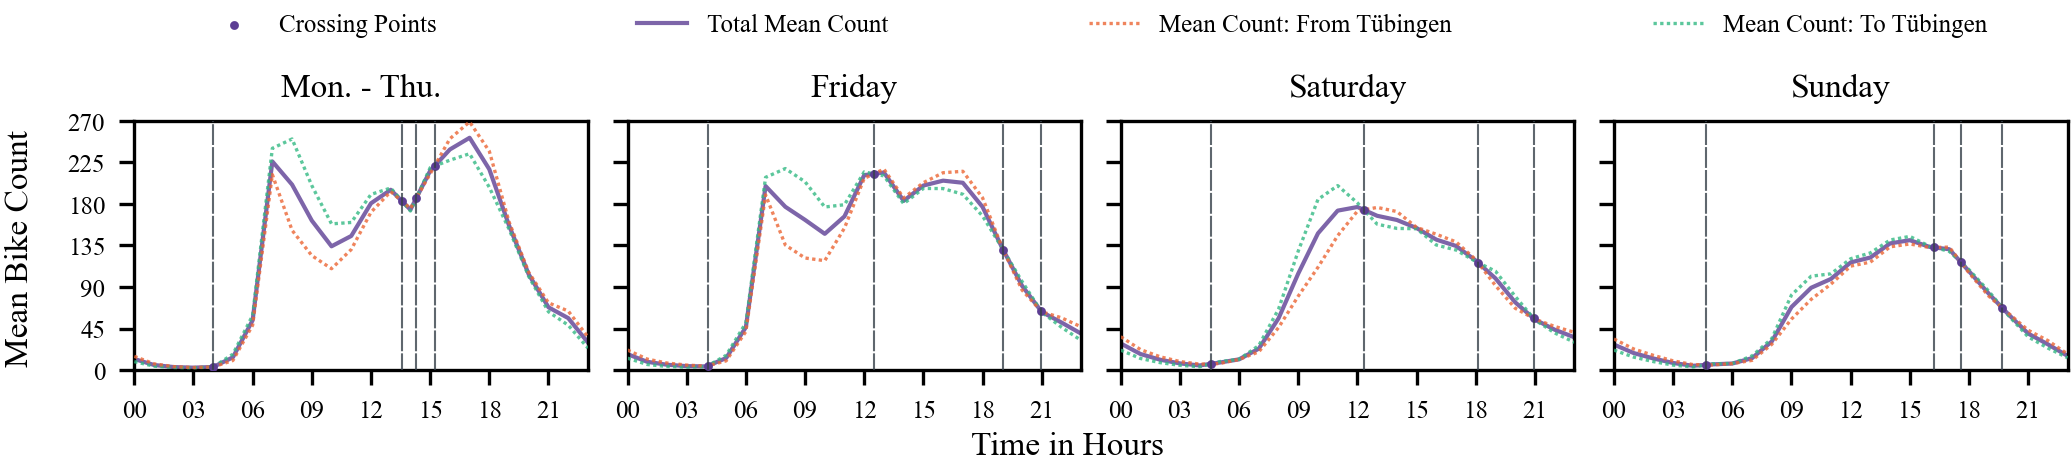

In [4]:
df = bd.get_hourly_data(counter_id=[100003358, 100003359])
weekdays = df[df["weekday"].isin([0, 1, 2, 3])].copy()
friday = df[df["weekday"] == 4].copy()
saturday = df[df["weekday"] == 5].copy()
sunday = df[df["weekday"] == 6].copy()
data = [weekdays, friday, saturday, sunday]
labels = ["Mon. - Thu.", "Friday", "Saturday", "Sunday"]

plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.icml2022(column="full", family="serif", usetex=False, nrows=1.2, ncols=4))
plt.rcParams['font.serif'] = "Times New Roman"

fig, axs = plt.subplots(1, 4, sharey=True)
axs = axs.flatten()

msz = 2
lw = .8
alph = .8
alph_fill = 0.5
colors = [ct.PRIMARY_COLORS[2], ct.PRIMARY_COLORS[1], ct.COUNTER_COLORS[-1], ct.AREA_COLORS[0]]
linestyles =  [(0, (1, 1)), (0, (1, 1)), "-"]

for i, ax in enumerate(axs):
    weekday_data = data[i]
    weekday_data.set_index("iso_timestamp", inplace=True)
    weekday_mean = weekday_data.groupby(weekday_data.index.hour)["zählstand"].mean()
    in_data = weekday_data[weekday_data["channel_id"] == "in"].copy()
    in_mean = in_data.groupby(in_data.index.hour)["zählstand"].mean()
    out_data = weekday_data[weekday_data["channel_id"] == "out"].copy()
    out_mean = out_data.groupby(out_data.index.hour)["zählstand"].mean()
    
    ax.plot(
        in_mean.index,
        in_mean,
        lw=lw,
        ls=linestyles[0],
        alpha=alph,
        color=colors[0],
        label="Mean Count: To Tübingen",
        zorder=5
    )
    ax.plot(
        out_mean.index,
        out_mean,
        lw=lw,
        ls=linestyles[1],
        color=colors[1],
        label="Mean Count: From Tübingen",
        alpha=alph,
        zorder=5
    )
    ax.plot(
        weekday_mean.index,
        weekday_mean,
        lw=1,
        ls=linestyles[2],
        alpha=.8,
        color=colors[2],
        label="Total Mean Count",
        zorder=0
    )
    # get intersections
    first_line = LineString(np.column_stack((in_mean.index, in_mean.values)))
    second_line = LineString(np.column_stack((out_mean.index, out_mean.values)))
    intersection = first_line.intersection(second_line)
    intersection_points = [p.coords[0] for p in intersection.geoms]

    has_label = True
    for x, y in intersection_points:
        label = "_nolabel_"
        if has_label:
            label = "Crossing Points"
            has_label = False
        ax.scatter(
            x,y,
            color=colors[2], 
            s=5,
            marker=".",
            label="Crossing Points",
            alpha=1,
            zorder=10
        )    
        ax.axvline(
            x,
            c=ct.NEUTRAL_COLORS[0],
            alpha=.8, 
            linestyle=(2,(10,1)), 
            zorder=10,
            label=label,
            lw=.5
        )
    ax.set_title(labels[i])
    # if i % 2 == 0:
    #     ax.set_ylabel("Mean Counted Bikes")
    # if i >= 2:
    #     ax.set_xlabel("Hour of Day")
    # l = np.arange(0, , 0.25)
    # ax.set(yticks=l, yticklabels=l)
    ax.set_ylim(0, 270)
    ax.set_yticks(range(0, 300, 45))
    ax.set_xticks(range(0, 20+3, 3))
    ax.set_xlim(0,23)
    ax.set_xticklabels([f"{h:02d}" for h in range(0, 20+3, 3)])
    # ax.set_xticks(range(0, 24+4, 4))
    # ax.set_xticklabels([f"{h:02d}" for h in range(0, 24+4, 4)])
    # ax.grid(lw=0.3, ls="-", alpha=.5)
fig.text(0.5, -0.05, 'Time in Hours', ha='center')
fig.text(-0.025, 0.5, 'Mean Bike Count', va='center', rotation='vertical')
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
unique.reverse()
# fig.legend(*zip(*unique), bbox_to_anchor=(0.5,1.125), loc="upper center", ncol=2, frameon=False)
# plt.suptitle("Mean Hourly Counts @ Fahrradtunnel & Steinlachallee")
fig.legend(*zip(*unique), bbox_to_anchor=(.065,1,.9,0.2), mode="expand", loc="lower center", ncol=4, frameon=False)
fig.align_labels()
# plt.show()
plt.savefig("fig_daily_directions.pdf")